# Loading word embeddings

In [2]:
import io
import numpy as np

In [11]:
def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            #print(line.rstrip())
            try:
                word, vect = line.rstrip().split(' ', 1)
            except: continue
            vect = np.fromstring(vect, sep=' ')
            #assert word not in word2id, 'word found twice'
            if word in word2id: continue
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [12]:
src_path = 'model_es.txt'
tgt_path = 'model_en.txt'
nmax = 50000  # maximum number of word embeddings to load

src_embeddings, src_id2word, src_word2id = load_vec(src_path, nmax)
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec(tgt_path, nmax)

# Get nearest neighbors

In [13]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

In [15]:
# printing nearest neighbors in the source space
src_word = 'gato'
get_nn(src_word, src_embeddings, src_id2word, src_embeddings, src_id2word, K=5)

Nearest neighbors of "gato":
1.0000 - gato
0.8082 - cuello
0.7981 - carro
0.7811 - monte
0.7718 - ladrón


In [16]:
# printing nearest neighbors in the target space
src_word = 'gato'
get_nn(src_word, src_embeddings, src_id2word, tgt_embeddings, tgt_id2word, K=5)

Nearest neighbors of "gato":
0.3097 - Orthodoxy
0.2833 - kind
0.2706 - years
0.2647 - sort
0.2608 - adventure


# Visualize multilingual embeddings

In [17]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, whiten=True)  # TSNE(n_components=2, n_iter=3000, verbose=2)
pca.fit(np.vstack([src_embeddings, tgt_embeddings]))
print('Variance explained: %.2f' % pca.explained_variance_ratio_.sum())

Variance explained: 0.10


In [18]:
import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find tsne coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontsize=19,
                     color=color, weight='bold')

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title('Visualization of the multilingual word embedding space')

    plt.show()

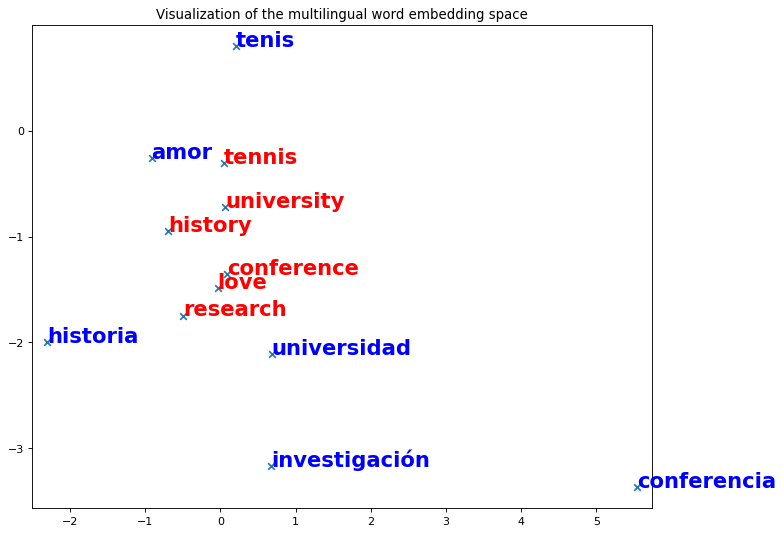

In [19]:
# get 5 random input words
src_words = ['universidad', 'amor', 'historia', u'tenis',  u'investigación', 'conferencia']
tgt_words = ['university', 'love', 'history', 'tennis', 'research', 'conference']

# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

plot_similar_word(src_words, src_word2id, src_embeddings, tgt_words, tgt_word2id, tgt_embeddings, pca)